Fermentation bioreactor model

If you use this model, please cite the following paper

Z. K. Nagy, Model Based Control of a Fermentation Bioreactor using Optimally Designed Artificial Neural Networks, Chemical Engineering Journal, 127, 95-109, 2007.

Copyright 2000-2007, Zoltan K. Nagy

In [2]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 14
LARGE_SIZE = 16

plt.rc("font",size=LARGE_SIZE)
plt.rc("axes",titlesize=LARGE_SIZE)
plt.rc("axes",labelsize=LARGE_SIZE)
plt.rc("xtick",labelsize=LARGE_SIZE)
plt.rc("ytick",labelsize=LARGE_SIZE)
plt.rc("legend",fontsize=LARGE_SIZE)
plt.rc("figure",titlesize=LARGE_SIZE)

In [4]:
### Physical Constant ###
### DO NOT EDIT ###

# Specific Ionic constants     (l/g_ion)

HNa  = -0.550
HCa  = -0.303
HMg  = -0.314
HH   = -0.774
HCl  =  0.844
HCO3 =  0.485
HHO  =  0.941


# Molecular masses     (g/mol)

MNaCl  = 58.5
MCaCO3 = 90
MMgCl2 = 95
MNa    = 23
MCa    = 40
MMg    = 24
MCl    = 35.5
MCO3   = 60 


# Kinetic constants
   
miu_P  = 1.790      # [1/h]
Ks     = 1.030      # [g/l]
Ks1    = 1.680      # [g/l]      
Kp     = 0.139      # [g/l]
Kp1    = 0.070      # [g/l]
Rsx    = 0.607
Rsp    = 0.435
YO2    = 0.970      # [mg/mg]
KO2    = 8.86       # [mg/l]
miu_O2 = 0.5        # [1/h]
A1     = 9.5e8
A2     = 2.55e33
Ea1    = 55000      # J/mol
Ea2    = 220000     # J/mol
R      = 8.31       # J/(mol.K)


# thermodynamic constants

Kla0   = 38        # [1/h]
KT     = 100*3600  # [J/hm2K]
Vm     = 50        # [l]
AT     = 1         # [m2]
ro     = 1080      # [g/l]
ccal   = 4.18      # [J/gK]         
roag   = 1000      # [g/l]
ccalag = 4.18      # [J/gK]
deltaH = 518       # [kJ/mol O2 consumat]

 
# Initial data

mNaCl  = 500        # [g]
mCaCO3 = 100        # [g]
mMgCl2 = 100        # [g]
pH     = 6
Tiag   = 15         # [癈]


# Initial Conditions

x0 = [1000, 0.90467678228155, 12.51524128083789, 29.73892382828279, 3.10695341758232, 29.57321214183856, 27.05393890970931]


In [5]:
### Process Model Function ###
### DO NOT EDIT ###

def model(t,vars,Fi,Fe,T_in,cS_in,Fag):
    V, cX, cP, cS, cO2, T, Tag = vars

    c0st = 14.16 - 0.3943 * T + 0.007714 * T**2 - 0.0000646 * T**3 # [mg/l]

    cNa  = mNaCl/MNaCl*MNa/V
    cCa  = mCaCO3/MCaCO3*MCa/V
    cMg  = mMgCl2/MMgCl2*MMg/V
    cCl  = (mNaCl/MNaCl + 2*mMgCl2/MMgCl2)*MCl/V
    cCO3 = mCaCO3/MCaCO3*MCO3/V
    cH   = 10**(-pH)
    cOH  = 10**(-(14-pH))

    INa  = 0.5*cNa*((+1)**2)
    ICa  = 0.5*cCa*((+2)**2)
    IMg  = 0.5*cMg*((+2)**2)
    ICl  = 0.5*cCl*((-1)**2)
    ICO3 = 0.5*cCO3*((-2)**2)
    IH   = 0.5*cH*((+1)**2)
    IOH  = 0.5*cOH*((-1)**2)

    sumaHiIi = HNa*INa+HCa*ICa+HMg*IMg+HCl*ICl+HCO3*ICO3+HH*IH+HHO*IOH
    cst  = c0st * 10**(-sumaHiIi)
    Kla  = Kla0*(1.024**(T-20))
    rO2 = miu_O2 * cO2 * cX/YO2/(KO2 + cO2)*1000  # mg/lh
    miu_X = A1*np.exp(-Ea1/R/(T+273)) - A2*np.exp(-Ea2/R/(T+273))

    dV   = Fi(t) - Fe(t)
    dcX  = miu_X * cX * cS / (Ks + cS) * np.exp(-Kp * cP) - (Fe(t)/V)*cX     # g/(l.h)
    dcP  = miu_P * cX * cS / (Ks1 + cS) * np.exp(-Kp1 * cP) - (Fe(t)/V)*cP   # g/(l.h)
    dcS  = - miu_X * cX * cS / (Ks + cS) * np.exp(-Kp * cP) / Rsx - miu_P * cX * cS / (Ks1 + cS) * np.exp(-Kp1 * cP) / Rsp + (Fi(t)/V)*cS_in(t) - (Fe(t)/V)*cS                                    # g/(l.h)
    dcO2 = Kla * (cst - cO2) - rO2 - (Fe(t)/V)*cO2                        # mg/(l.h)
    dT   = (1/32*V*rO2*deltaH - KT*AT*(T - Tag) + Fi(t)*ro*ccal*(T_in(t)+273) - Fe(t)*ro*ccal*(T+273))/(ro*ccal*V)    # J/h
    dTag = (Fag(t)*ccalag*roag*(Tiag - Tag) + KT*AT*(T - Tag)) / (Vm * roag * ccalag)                                        # J/h

    return [dV, dcX, dcP, dcS, dcO2, dT, dTag]


In [6]:
### Simulate the System ###

# Simulation time
t_final = 100
t_delay = 3
t_eval = np.linspace(0,t_final-t_delay,t_final*100)

# Process input. You may need to change this
Fi = lambda t: 51
Fe = lambda t: 51
T_in = lambda t: 25
cS_in = lambda t: 60
Fag = lambda t: 18

sol = scipy.integrate.solve_ivp(model, [0,t_final-t_delay],x0,args=(Fi,Fe,T_in,cS_in,Fag), t_eval=t_eval)

<>:37: SyntaxWarning: invalid escape sequence '\c'
<>:43: SyntaxWarning: invalid escape sequence '\c'
<>:37: SyntaxWarning: invalid escape sequence '\c'
<>:43: SyntaxWarning: invalid escape sequence '\c'
/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_25196/3615498738.py:37: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel("Tank Temperature ($^{\circ} C$)")
/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_25196/3615498738.py:43: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel("Cooling Water Temperature ($^{\circ} C$)")


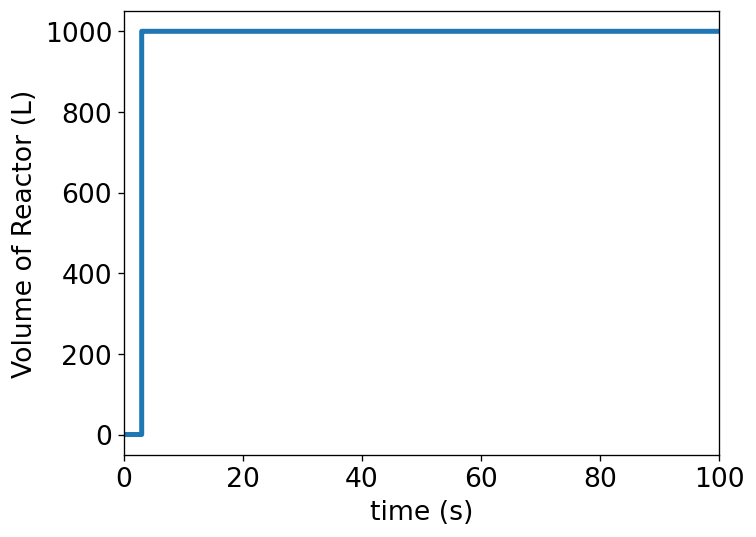

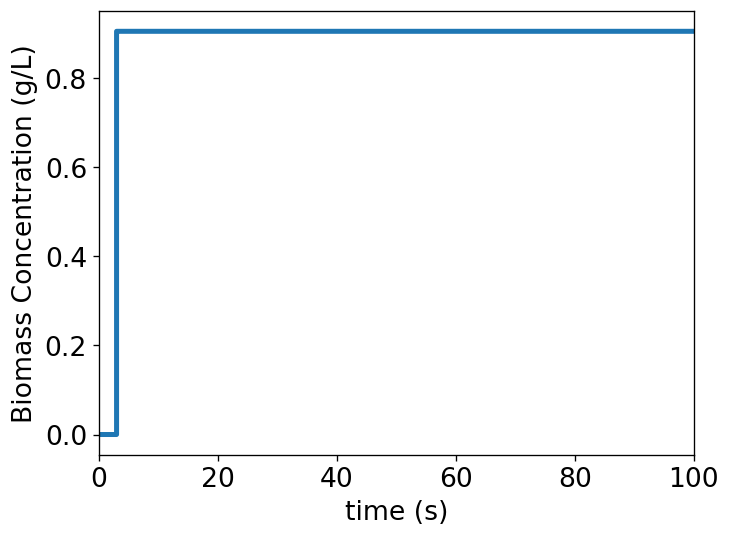

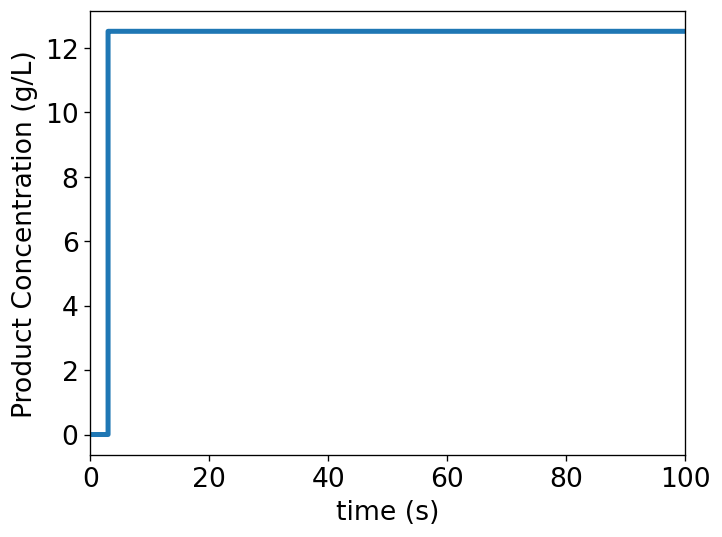

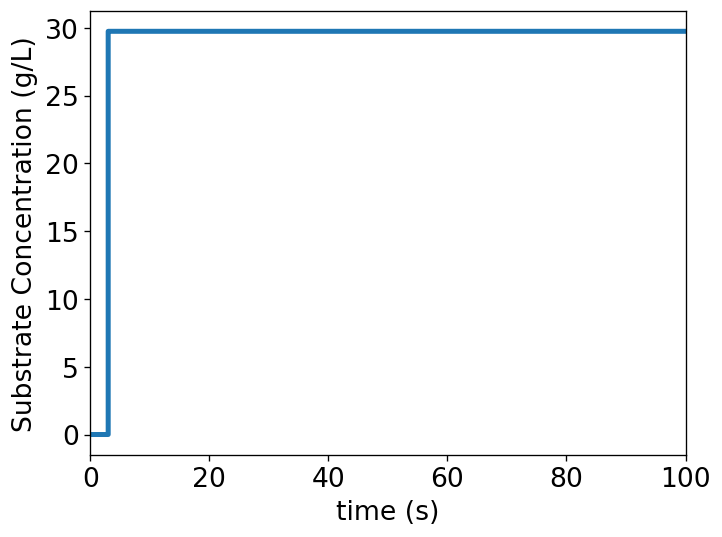

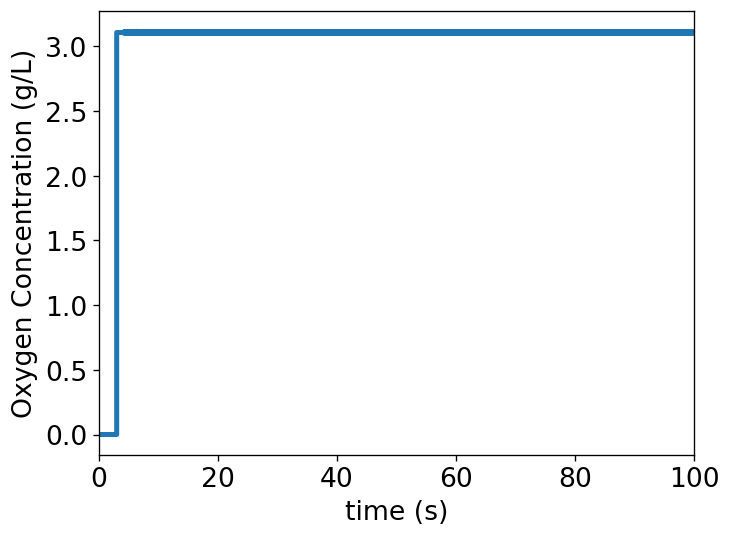

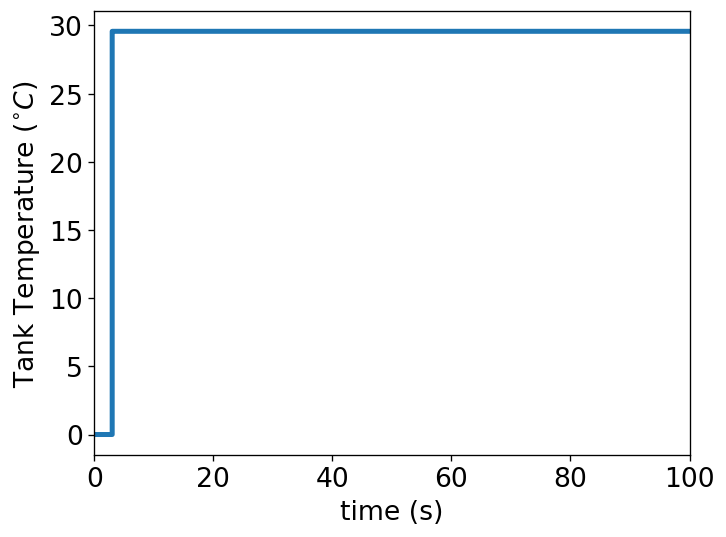

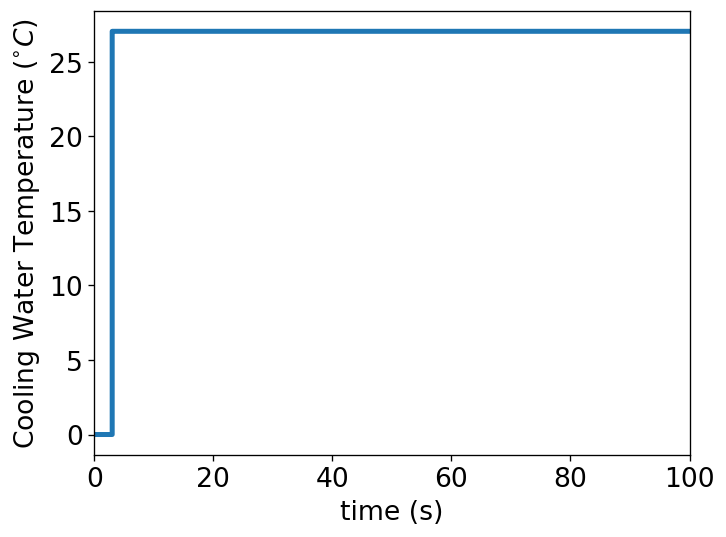

In [7]:
### Ploting ###

plt.figure(dpi=120)
plt.plot([0,t_delay, *(t_delay + sol.t)],[0,0,*sol.y[0]],lw=3)
plt.xlim([0,t_final])
plt.xlabel("time (s)")
plt.ylabel("Volume of Reactor (L)")

plt.figure(dpi=120)
plt.plot([0,t_delay, *(t_delay + sol.t)],[0,0,*sol.y[1]],lw=3)
plt.xlim([0,t_final])
plt.xlabel("time (s)")
plt.ylabel("Biomass Concentration (g/L)")

plt.figure(dpi=120)
plt.plot([0,t_delay, *(t_delay + sol.t)],[0,0,*sol.y[2]],lw=3)
plt.xlim([0,t_final])
plt.xlabel("time (s)")
plt.ylabel("Product Concentration (g/L)")

plt.figure(dpi=120)
plt.plot([0,t_delay, *(t_delay + sol.t)],[0,0,*sol.y[3]],lw=3)
plt.xlim([0,t_final])
plt.xlabel("time (s)")
plt.ylabel("Substrate Concentration (g/L)")

plt.figure(dpi=120)
plt.plot([0,t_delay, *(t_delay + sol.t)],[0,0,*sol.y[4]],lw=3)
plt.xlim([0,t_final])
plt.xlabel("time (s)")
plt.ylabel("Oxygen Concentration (g/L)")

plt.figure(dpi=120)
plt.plot([0,t_delay, *(t_delay + sol.t)],[0,0,*sol.y[5]],lw=3)
plt.xlim([0,t_final])
plt.xlabel("time (s)")
plt.ylabel("Tank Temperature ($^{\circ} C$)")

plt.figure(dpi=120)
plt.plot([0,t_delay, *(t_delay + sol.t)],[0,0,*sol.y[6]],lw=3)
plt.xlim([0,t_final])
plt.xlabel("time (s)")
plt.ylabel("Cooling Water Temperature ($^{\circ} C$)")
plt.show()